Combines two previously created figures for the purposes of PNAS submission.

a) Total rainfall
b) Rainband frequency
c) Mean rainband intensity
d) Freq and Intensity curves

In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import netCDF4 as nc
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autotime
from bootstrap import *
import numpy.ma as ma
from chr_matplotlib import remappedColorMap
from shutil import copy

from jd_matplotlib_tools import add_double_calendar_axis, mark_time_periods

In [2]:
ferretpath = "/Users/Siwen/Desktop/ferret/bin"
rdapath = "APHRO_ZH_front_025deg_V1101."

time: 756 µs


In [3]:
## start by loading all precipitation data for each year.
P = np.zeros((365,80,72,57))

for yr in range(1951,2008):
    
    #Build filename
    filename = ferretpath + '/' + rdapath + str(yr) + '.nc'
    print(filename),
    myf = nc.Dataset(filename, 'r')
    
    #Obtain fraction of different types of rainfall
    P[:,:,:,yr-1951] = myf['P'][:365,:,:]
    myf.close()
    
P_mean = np.nanmean(P, axis=(2,3))

/Users/Siwen/Desktop/ferret/bin/APHRO_ZH_front_025deg_V1101.1951.nc
/Users/Siwen/Desktop/ferret/bin/APHRO_ZH_front_025deg_V1101.1952.nc
/Users/Siwen/Desktop/ferret/bin/APHRO_ZH_front_025deg_V1101.1953.nc
/Users/Siwen/Desktop/ferret/bin/APHRO_ZH_front_025deg_V1101.1954.nc
/Users/Siwen/Desktop/ferret/bin/APHRO_ZH_front_025deg_V1101.1955.nc
/Users/Siwen/Desktop/ferret/bin/APHRO_ZH_front_025deg_V1101.1956.nc
/Users/Siwen/Desktop/ferret/bin/APHRO_ZH_front_025deg_V1101.1957.nc
/Users/Siwen/Desktop/ferret/bin/APHRO_ZH_front_025deg_V1101.1958.nc
/Users/Siwen/Desktop/ferret/bin/APHRO_ZH_front_025deg_V1101.1959.nc
/Users/Siwen/Desktop/ferret/bin/APHRO_ZH_front_025deg_V1101.1960.nc
/Users/Siwen/Desktop/ferret/bin/APHRO_ZH_front_025deg_V1101.1961.nc
/Users/Siwen/Desktop/ferret/bin/APHRO_ZH_front_025deg_V1101.1962.nc
/Users/Siwen/Desktop/ferret/bin/APHRO_ZH_front_025deg_V1101.1963.nc
/Users/Siwen/Desktop/ferret/bin/APHRO_ZH_front_025deg_V1101.1964.nc
/Users/Siwen/Desktop/ferret/bin/APHRO_ZH_front_0

In [4]:
def smooth(P,dayrange,latrange):
    Psmooth=np.zeros(P.shape)
    
    ll=int((dayrange-1)/2)
    yy=int((latrange-1)/2)
    
    days = P.shape[0]
    lats = P.shape[1]
    
    for d in range(days):
        for j in range(lats):
            
            Psample = P.take(range(d-ll,d+ll+1), mode='wrap', axis=0)
            Ps = Psample[:,max(0,j-yy):min(days,j+yy+1)]
            Psmooth[d,j] = np.mean(np.mean(Ps))
    
    return Psmooth

time: 7.18 ms


In [5]:
## SMOOTHING ##
#smooth out the decadal precipitation means
#but, no latitudinal smoothing since rainfall already effectively smoothed in latitude
daysmth = 15
latsmth = 0

P_smth = smooth(P_mean,daysmth,latsmth)

time: 729 ms


In [6]:
## CLIMATOLOGY PLOT ##

## LOAD FROM NETCDF ##
ferretdir = "/Users/Siwen/Desktop/Ferret/bin/"

#bounding years for climatology
yb=1951 
ye=2007

#load 57-year climatology
yb_last2= str(yb-1900)
print(yb_last2)
ye_last2= str("{0:0=2d}".format((ye-1900)%100))
print(ye_last2)

51
07
time: 2.83 ms


In [7]:
## LOAD FREQUENCY HOVMOLLER ##
loadfile = "RDA_freq_hov"
loadname = ferretdir + loadfile + '.nc'

#import from netCDF file
freq_climo_netcdf = nc.Dataset(loadname, "r")
freq_climo = freq_climo_netcdf['lat_hov_smth_' + yb_last2 + ye_last2][:]

#close it
freq_climo_netcdf.close()

time: 17.9 ms


In [8]:
## LOAD INTENSITY HOVMOLLER CLIMATOLOGY ##
loadfile = "RDA_int_climo"
loadname = ferretdir + loadfile + '.nc'

#import from netCDF file and load 57-year climatology
int_climo_netcdf = nc.Dataset(loadname, "r")
int_climo = int_climo_netcdf['int_mean_' + yb_last2 + ye_last2][:]

#load daily mean for all latitudes
int_climo_daily = int_climo_netcdf['int_climo_mean'][:]
int_climo_daily_lb =  int_climo_netcdf['int_climo_lb'][:]
int_climo_daily_ub =  int_climo_netcdf['int_climo_ub'][:]


#close it
int_climo_netcdf.close()


time: 22 ms


In [9]:
#print(int_climo_daily)

time: 436 µs


In [10]:
## DEFINE TIME PERIODS OF INTEREST
time_periods = [[80.5,120.5],[120.5,160.5],[160.5,200.5],[200.5,273.5],[273.5,320.5]]

time: 1.04 ms


//anaconda/lib/python3.5/site-packages/matplotlib/text.py:2130: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  warnings.warn("You have used the `textcoords` kwarg, but not "


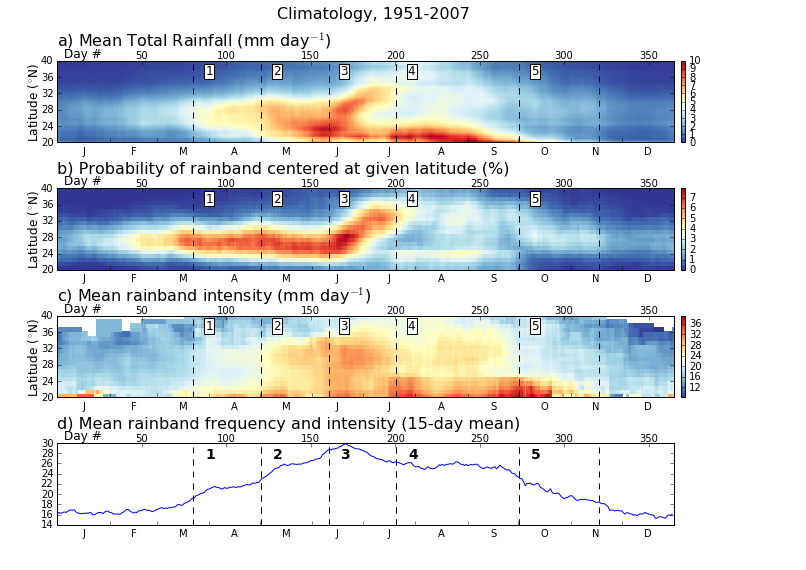

time: 2.38 s


In [48]:
## CLIMATOLOGY PLOT ##

fig, ax = plt.subplots(figsize=(11,8))
ax.set_title("Climatology, 1951-2007", fontsize=16, y = 1.08, x=.43)
mypalette = 'RdYlBu_r'
ax.set_axis_off()

cbpad = .01 #default color bar padding.

## Rainfall climatology
ax1 = fig.add_subplot(4,1,1)
plot1 = ax1.pcolormesh(P_smth.T, cmap = mypalette, vmin = 0, vmax = 10); 
ax1.set_title("a) Mean Total Rainfall (mm day$^{-1}$)", fontsize=16, y=1.12, loc = 'left')
plt.ylabel('Latitude ($^\circ\!$N)', fontsize=12, labelpad=0)
plt.yticks(np.linspace(0,80,6),np.linspace(20,40,6).astype(int))

cbar1 = plt.colorbar(plot1, pad=cbpad)

add_double_calendar_axis()
mark_time_periods(time_periods, numbers = 'yes')


## Frequency climatology
ax2 = fig.add_subplot(4,1,2)
plot2 = ax2.pcolormesh(100*freq_climo[:,1:21].T, cmap = mypalette); 
plt.ylabel('Latitude ($^\circ\!$N)', fontsize=12, labelpad=0)
plt.yticks(np.linspace(0,20,6),np.linspace(20,40,6).astype(int))

cbar2 = plt.colorbar(plot2, pad=cbpad)
cbar2.set_ticks(np.linspace(0, 8, 9))

ax2.set_title("b) Probability of rainband centered at given latitude (%)", fontsize=16, y=1.12, loc = 'left')

add_double_calendar_axis()
mark_time_periods(time_periods, numbers = 'yes')


## Intensity climatology
ax3 = fig.add_subplot(4,1,3)
plot3 = ax3.pcolormesh(int_climo[:,1:21].T, cmap = mypalette); 
plt.ylabel('Latitude ($^\circ\!$N)', fontsize=12, labelpad=0)
plt.yticks(np.linspace(0,20,6),np.linspace(20,40,6).astype(int))

cbar3 = plt.colorbar(plot3, pad=cbpad)
ax3.set_title("c) Mean rainband intensity (mm day$^{-1}$)", fontsize=16, y=1.12, loc = 'left')

add_double_calendar_axis()
mark_time_periods(time_periods, numbers = 'yes')


## Event means
ax4 = fig.add_subplot(4,1,4)
plot4 = ax4.plot(int_climo_daily); 
#plt.ylabel('Latitude ($\!^\circ\!$)', fontsize=12, labelpad=0)
#plt.yticks(np.linspace(0,20,6),np.linspace(20,40,6).astype(int))

ax4.set_title("d) Mean rainband frequency and intensity (15-day mean)", fontsize=16, y=1.12, loc = 'left')

add_double_calendar_axis()

## reset subpanel positioning
plt.tight_layout(pad=0, w_pad=0, h_pad=0)

#tweak width of subpanel d
pos3 = ax3.get_position() # get the original position 
pos4_old = ax4.get_position() # get the original position 
pos4_new = [pos4_old.x0, pos4_old.y0, pos3.width, pos4_old.height] 
ax4.set_position(pos4_new) # set a new position

#rescale all axes in panel d
axx = fig.get_axes()
axx[-1].set_position(pos4_new)
axx[-2].set_position(pos4_new)

#add time periods to panel d
mark_time_periods(time_periods, numbers = 'yes')
plt.text(.01, 1.04, 'Day #', transform=ax4.transAxes, size=12)

for i, p in enumerate(time_periods):
    plt.text((p[0]+7)/365, .95, i+1, transform=ax4.transAxes, fontsize=14, fontweight = 'bold', verticalalignment='top')

In [12]:
## SAVE COPY TO MANUSCRIPT AND ANALYSIS DIRECTORIES
figure_name = "PNAS_climo.pdf"

savepath = "/Users/Siwen/Desktop/RDA/Figures/" + figure_name

if os.path.exists(savepath):
    print("Overwriting existing version of file in RDA manuscript directory...")
    os.remove(savepath)

plt.savefig(savepath)
    
copypath = "/Users/Siwen/RDA/Figures/" + figure_name
    
if os.path.exists(copypath):
    print("Overwriting existing version of file in RDA Python directory...")
    os.remove(copypath)
    
copy(savepath,copypath)


Overwriting existing version of file in RDA manuscript directory...
Overwriting existing version of file in RDA Python directory...


'/Users/Siwen/RDA/Figures/PNAS_climo.pdf'

time: 17.7 ms
